In [2]:
from __future__ import print_function, division
import os
import torch


# DataLoader은 Dataset을 샘플에 쉽게 접근할 수 있도록 순회가능한 객체(iterable)로 감쌉니다
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets
from torchvision.transforms import ToTensor
import torchvision.models as models 

import pprint
from datetime import datetime



import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR


from auto_encoder import MNIST_BN_32_64_256, ae_train

from active_learn import argparser

In [4]:
import numpy as np
original_data = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=ToTensor()
    )


original_all = []
original_dataset = []
original_label = [] 

for sample in original_data : 
    original_all.append(sample)
    feature = np.array(sample[0])
    original_dataset.append(feature)
    original_label.append(sample[1])
    
unlabeled_dataset = original_dataset[:]
unlabeled_dataset_label = original_label[:]
labeled_dataset = [] 
labeled_dataset_label = []

In [5]:
use_cuda = True


device = torch.device("cuda" if use_cuda else "cpu")
    # use_cuda가 true라면 kwargs를 다음과 같이 지정하기. 
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

    # 데이터 변경시 수정 필요 
ae_training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor())
    # 데이터 변경시 수정 필요 
ae_test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor())

kwargs = {'num_workers': 1, 'pin_memory': True} if True else {}

In [9]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, input_size, cnn_kernel, cnn_stride, cnn_padding):
    super(ConvAutoEncoder, self).__init__()
    
    # Encoder
    self.cnn_layer1 = nn.Sequential(
      # (1,28,28) -> (16,16,16)
      nn.Conv2d(1, 16, kernel_size = cnn_kernel, stride=cnn_stride, padding=2),
      nn.ReLU(),
      nn.BatchNorm2d(16), 
      # (16,16,16) -> (32, 8, 8)
      nn.Conv2d(16, 32, kernel_size = cnn_kernel, stride=cnn_stride, padding=cnn_padding),
      nn.ReLU(), 
      nn.BatchNorm2d(32), 
      # (32, 8, 8) -> (64, 4, 4)
      nn.Conv2d(32, 64, kernel_size = cnn_kernel, stride=cnn_stride, padding=cnn_padding),
      nn.ReLU(), 
      nn.BatchNorm2d(64),
      #(64, 4, 4) -> (64, 2,2)
      nn.MaxPool2d(2,2)
      )


    self.fc_encoder = nn.Sequential(
      nn.Linear(256, 64),
      nn.ReLU(),
      nn.Linear(64, 8),
      nn.ReLU(),
      nn.Linear(8, 2),
      nn.ReLU()
    )

    self.fc_decoder = nn.Sequential(
      nn.Linear(2, 8),
      nn.ReLU(),
      nn.Linear(8, 64),
      nn.ReLU(),
      nn.Linear(64, 256),
      nn.ReLU()
    )

    # Decoder 
    # ConvTranspose2d : output H/W = Kernel size + stride(input size -1) - 2 padding
    # (N, 3, cnn2_size, cnn2_size) => (N, 3, cnn1_size, cnn1_size)
    self.tran_cnn_layer1 = nn.Sequential(
      nn.ConvTranspose2d(64, 64, kernel_size = cnn_kernel, stride =cnn_stride, padding =cnn_padding),
      nn.ReLU(),
      nn.BatchNorm2d(64), 
      nn.ConvTranspose2d(64, 32, kernel_size = cnn_kernel, stride =cnn_stride, padding =cnn_padding),
      nn.ReLU(),
      nn.BatchNorm2d(32),
      nn.ConvTranspose2d(32, 16, kernel_size = cnn_kernel, stride =cnn_stride, padding =cnn_padding),
      nn.ReLU(),
      nn.BatchNorm2d(16),
      #(16, 16, 16) => (1, 28, 28)
      nn.ConvTranspose2d(16, 1, kernel_size = cnn_kernel, stride =cnn_stride, padding =2),
      nn.ReLU()
    )

    
  def forward(self, x):
    out = self.cnn_layer1(x)
    out = torch.flatten(out, 1) # batchsize - 64, 32 * cnn2^2  
    out = self.fc_encoder(out) # 64, 32 * cnn2^2 -> 64, 2
    out = self.fc_decoder(out) # 64, 2 => 64, 32 * cnn2^2 2048
    out = out.view(len(x), 64, 2, 2)  # (batch_size, , H, W)
    out = self.tran_cnn_layer1(out)
    return out

  def get_codes(self, x):
    out = self.cnn_layer1(x) 
    out = torch.flatten(out, 1)
    out = self.fc_encoder(out)
    return out 

In [4]:
AE = MNIST_BN_32_64_256(10, 2)
AE_loss = nn.MSELoss()

    
AE = AE.to(device)

AE_optimizer = optim.Adam(AE.parameters(), lr=0.001)


In [5]:
ae_train(AE, ae_training_data, ae_test_data, device, AE_loss, AE_optimizer, 50, kwargs)

Epoch [0/50], Train Loss: 66.4009, Test Loss: 8.6346 *
Epoch [10/50], Train Loss: 37.7085, Test Loss: 6.1433 *
Epoch [20/50], Train Loss: 36.0642, Test Loss: 5.9384 *
Epoch [30/50], Train Loss: 35.2442, Test Loss: 5.8541 *
Epoch [40/50], Train Loss: 34.6748, Test Loss: 5.7733 *


In [5]:
PATH = './weights/MNIST/'
if not os.path.exists(PATH): os.mkdir(PATH)

        # 한번만 Train을 시킬 방법이 없을까? 
ae_train(AE, ae_training_data, ae_test_data, device, AE_loss, AE_optimizer, 200, kwargs)

torch.save(AE, PATH + 'CAE.pt')  # 전체 모델 저장
    
torch.save(AE.state_dict(), PATH + 'CAE_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({'model': AE.state_dict(),
        'optimizer': AE_optimizer.state_dict()
    }, PATH + 'CAE_all.tar') 

Epoch [0/200], Train Loss: 64.2840, Test Loss: 9.7392 *
Epoch [10/200], Train Loss: 36.5596, Test Loss: 6.0318 *
Epoch [20/200], Train Loss: 35.0725, Test Loss: 5.8455 *
Epoch [30/200], Train Loss: 34.2586, Test Loss: 5.7100 *
Epoch [40/200], Train Loss: 33.8398, Test Loss: 5.6435 *
Epoch [50/200], Train Loss: 33.6228, Test Loss: 5.6383 *
Epoch [60/200], Train Loss: 33.3531, Test Loss: 5.5703 *
Epoch [70/200], Train Loss: 33.0642, Test Loss: 5.5627 *
Epoch [80/200], Train Loss: 33.0067, Test Loss: 5.5746
Epoch [90/200], Train Loss: 32.8135, Test Loss: 5.5239 *
Epoch [100/200], Train Loss: 32.6338, Test Loss: 5.5524
Epoch [110/200], Train Loss: 32.5695, Test Loss: 5.4864 *
Epoch [120/200], Train Loss: 32.5104, Test Loss: 5.5197
Epoch [130/200], Train Loss: 32.6238, Test Loss: 5.4821 *
Epoch [140/200], Train Loss: 32.4893, Test Loss: 5.5158
Epoch [150/200], Train Loss: 32.3975, Test Loss: 5.4536 *
Epoch [160/200], Train Loss: 32.3485, Test Loss: 5.4515 *
Epoch [170/200], Train Loss: 32.2

In [6]:
from active_learn import get_features
test = unlabeled_dataset[:1000]
test = torch.tensor(test)

a = get_features(AE, unlabeled_dataset, "cuda")
#b = AE(test)

C:\Users\user\AppData\Local\Temp\ipykernel_29324\3866845871.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:204.)
  test = torch.tensor(test)


In [6]:
from active_learn import get_features
PATH = './weights/MNIST/'
B = torch.load(PATH + 'CAE.pt')

b = get_features(B, unlabeled_dataset, "cuda")

In [10]:
set(b)

TypeError: unhashable type: 'numpy.ndarray'

<function matplotlib.pyplot.show(close=None, block=None)>

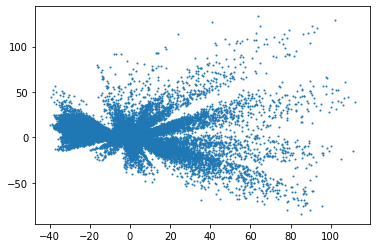

In [7]:
from matplotlib import pyplot as plt 
a = np.array(a)
x = a[:,0]
y = a[:,1]

plt.scatter(x,y, s=1)
plt.show